In [1]:
import numpy as np
import pandas as pd
import lifelines as ll

%matplotlib inline
import matplotlib.pyplot as plt

#larger
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5

from lifelines.estimation import KaplanMeierFitter

/Users/bwu/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
df.head()

,T,E,group
0,6.0,1,miR-137
1,13.0,1,miR-137
2,13.0,1,miR-137
3,13.0,1,miR-137
4,19.0,1,miR-137


In [4]:
T = df['T']
E = df['E']

In [5]:
#T is an array of durations
#E is a either boolean or binary array representing whether the “death” was observed (alternatively an individual can be censored).
#By default, lifelines assumes all “deaths” are observed.

In [6]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
kmf.fit(T, event_observed=E, label = "Bay Area Homes"); # more succiently, kmf.fit(T,E)

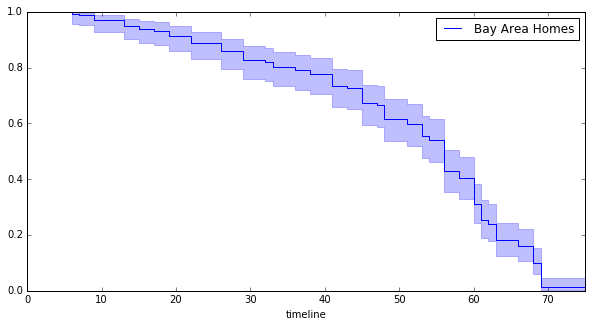

In [7]:
#After calling the fit method, we have access to new properties like survival_function_ and methods like plot(). 
#The latter is a wrapper around Pandas internal plotting library.
kmf.survival_function_
kmf.median_
kmf.plot();

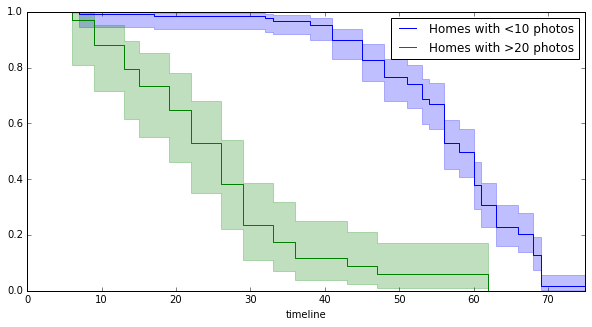

In [8]:
#Multiple Groups
groups = df['group']
ix = (groups == 'miR-137')

kmf.fit(T[~ix], E[~ix], label='Homes with <10 photos')
ax = kmf.plot()

kmf.fit(T[ix], E[ix], label='Homes with >20 photos')
kmf.plot(ax=ax);

In [9]:
from lifelines.utils import survival_table_from_events

table = survival_table_from_events(T, E)
table.head()

,removed,observed,censored,entrance,at_risk
event_at,,,,,
0.0,0.0,0.0,0.0,163.0,163.0
6.0,1.0,1.0,0.0,0.0,163.0
7.0,2.0,1.0,1.0,0.0,162.0
9.0,3.0,3.0,0.0,0.0,160.0
13.0,3.0,3.0,0.0,0.0,157.0


In [10]:
#While the above KaplanMeierFitter and NelsonAalenFitter are useful, they only give us an “average” view of the population. 
#Often we have specific data at the individual level, either continuous or categorical, that we would like to use. 
#For this, we turn to survival regression, specifically AalenAdditiveFitter or CoxPHFitter.

In [11]:
from lifelines.datasets import load_regression_dataset
regression_dataset = load_regression_dataset()
regression_dataset.head()

,var1,var2,var3,T,E
0,0.595170,1.143472,1.571079,14.785479,1
1,0.209325,0.184677,0.356980,7.336734,1
2,0.693919,0.071893,0.557960,5.271527,1
3,0.443804,1.364646,0.374221,11.684168,1
4,1.613324,0.125566,1.921325,7.637764,1


In [12]:
from lifelines import CoxPHFitter

# Using Cox Proportional Hazards model
cf = CoxPHFitter()
cf.fit(regression_dataset, 'T', event_col='E')
cf.print_summary()

n=200, number of events=189

          coef  exp(coef)  se(coef)         z         p  lower 0.95  upper 0.95    
var1 2.083e-01  1.232e+00 6.992e-02 2.980e+00 2.886e-03   7.126e-02   3.454e-01  **
var2 4.607e-02  1.047e+00 7.506e-02 6.139e-01 5.393e-01  -1.011e-01   1.932e-01    
var3 2.110e-01  1.235e+00 7.316e-02 2.884e+00 3.931e-03   6.754e-02   3.544e-01  **
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Concordance = 0.580


In [13]:
#After fitting, you’ll have access to properties like cumulative_hazards_ and 
#methods like plot, predict_cumulative_hazards, and predict_survival_function. 
#The latter two methods require an additional argument of individual covariates:

/Users/bwu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: using '-' to provide set differences with Indexes is deprecated, use .difference()
  if __name__ == '__main__':


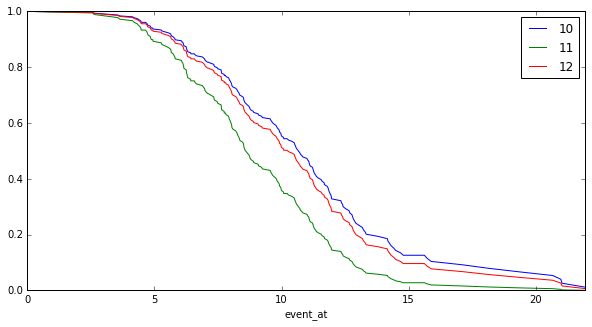

In [14]:
x = regression_dataset[regression_dataset.columns - ['E','T']]
cf.predict_survival_function(x.ix[10:12]).plot();

In [73]:
cf.predict_expectation(x.ix[10:12])

,0
10,10.882604
11,8.966119
12,10.409507


In [145]:
#For an experiment, using a canonical dataset called "Worcester Heart Attack Study (100 Patients)"
#https://www.umass.edu/statdata/statdata/stat-survival.html
#LENFOL: length of follow-up (days)
#FSTAT: loss to follow-up alive=0, death=1
#GENDER: males=0, females=1

In [19]:
df = pd.read_csv('whas100.csv')

In [20]:
df.head()

,id,admitdate,foldate,los,lenfol,fstat,age,gender,bmi
0,1,3/13/95,3/19/95,4,6,1,65,0,31.38134
1,2,1/14/95,1/23/96,5,374,1,88,1,22.65790
2,3,2/17/95,10/4/01,5,2421,1,77,0,27.87892
3,4,4/7/95,7/14/95,9,98,1,81,1,21.47878
4,5,2/9/95,5/29/98,4,1205,1,78,0,30.70601


In [21]:
kmf = KaplanMeierFitter()

In [22]:
T = df['lenfol']
C = df['fstat']

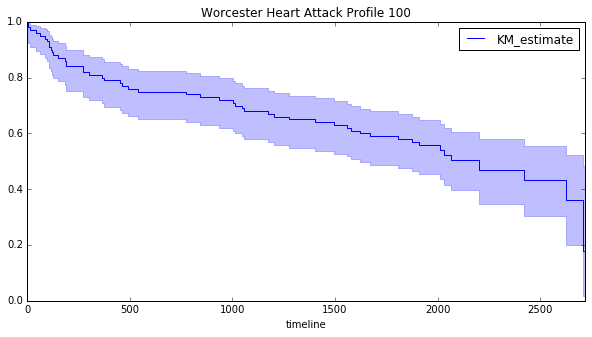

In [23]:
#kmf.fit(observed_lifetimes, event_observed=C)
kmf.fit(T, event_observed=C)
kmf.plot(title = 'Worcester Heart Attack Profile 100');

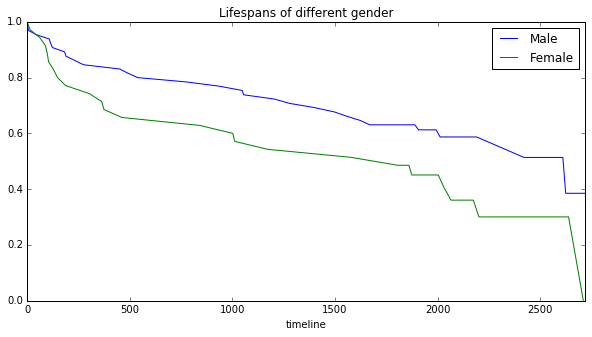

In [24]:
#male
f = df.gender==0
T = df[f]['lenfol']
C = df[f]['fstat']
#female
f2 = df.gender==1
T2 = df[f2]['lenfol']
C2 = df[f2]['fstat']

ax = plt.subplot(111)

kmf.fit(T, event_observed=C, label=['Male'])
kmf.survival_function_.plot(ax=ax)
kmf.fit(T2, event_observed=C2, label=['Female'])
kmf.survival_function_.plot(ax=ax)

plt.title('Lifespans of different gender')

kmf2 = plt.gcf()

#In the graph of the KM curve stratified by gender, 
#it means that females have a worse survival experience compared with male.

In [25]:
#Political regimes
data = ll.datasets.load_dd()

In [26]:
data.head()

,ctryname,cowcode2,politycode,un_region_name,un_continent_name,ehead,leaderspellreg,democracy,regime,start_year,duration,observed
0,Afghanistan,700,700.0,Southern Asia,Asia,Mohammad Zahir Shah,Mohammad Zahir Shah.Afghanistan.1946.1952.Mona...,Non-democracy,Monarchy,1946,7,1
1,Afghanistan,700,700.0,Southern Asia,Asia,Sardar Mohammad Daoud,Sardar Mohammad Daoud.Afghanistan.1953.1962.Ci...,Non-democracy,Civilian Dict,1953,10,1
2,Afghanistan,700,700.0,Southern Asia,Asia,Mohammad Zahir Shah,Mohammad Zahir Shah.Afghanistan.1963.1972.Mona...,Non-democracy,Monarchy,1963,10,1
3,Afghanistan,700,700.0,Southern Asia,Asia,Sardar Mohammad Daoud,Sardar Mohammad Daoud.Afghanistan.1973.1977.Ci...,Non-democracy,Civilian Dict,1973,5,0
4,Afghanistan,700,700.0,Southern Asia,Asia,Nur Mohammad Taraki,Nur Mohammad Taraki.Afghanistan.1978.1978.Civi...,Non-democracy,Civilian Dict,1978,1,0


In [27]:
kmf = KaplanMeierFitter()
T = data["duration"]
C = data["observed"]

kmf.fit(T, event_observed=C )

<lifelines.KaplanMeierFitter: fitted with 1808 observations, 340 censored>

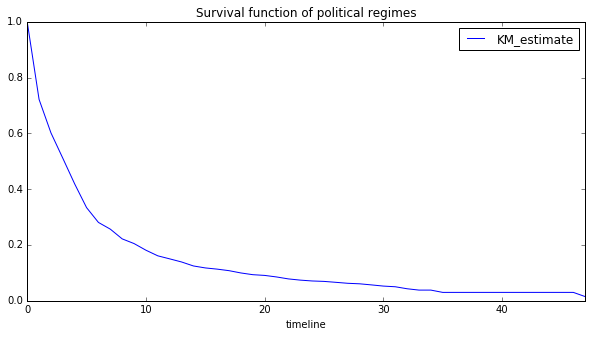

In [28]:
kmf.survival_function_.plot()
plt.title('Survival function of political regimes');

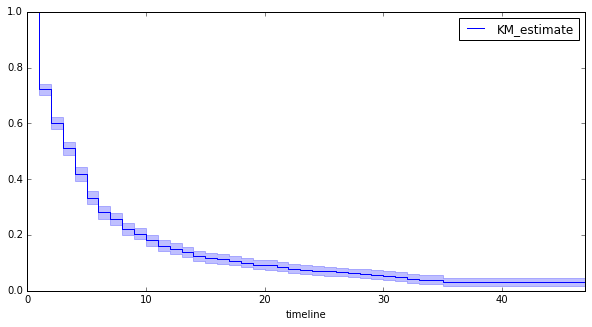

In [29]:
kmf.plot();

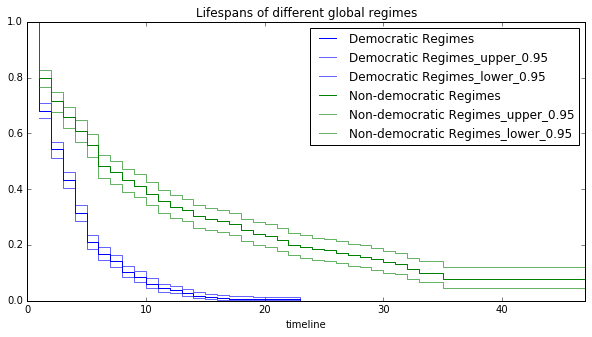

In [30]:
ax = plt.subplot(111)

dem = (data["democracy"] == "Democracy")
kmf.fit(T[dem], event_observed=C[dem], label="Democratic Regimes")
kmf.plot(ax=ax, ci_force_lines=True)
kmf.fit(T[~dem], event_observed=C[~dem], label="Non-democratic Regimes")
kmf.plot(ax=ax, ci_force_lines=True)

plt.ylim(0,1);
plt.title("Lifespans of different global regimes");

In [31]:
from lifelines.statistics import logrank_test

results = logrank_test(T[dem], T[~dem], C[dem], C[~dem], alpha=.99 )

results.print_summary()

Results
   df: 1
   alpha: 0.99
   t 0: -1
   test: logrank
   null distribution: chi squared

   __ p-value ___|__ test statistic __|____ test result ____|__ is significant __
         0.00000 |            260.470 |      Reject Null    |        True       


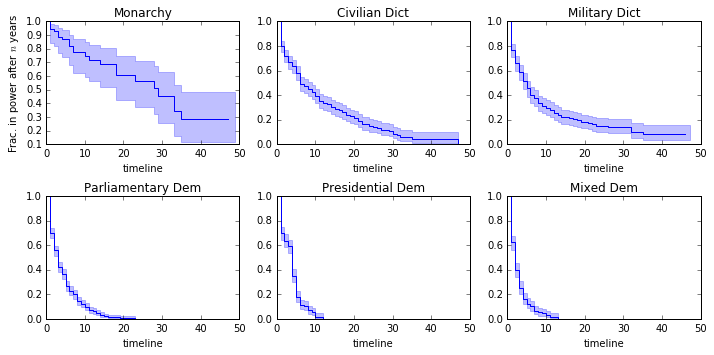

In [32]:
regime_types = data['regime'].unique()

for i,regime_type in enumerate(regime_types):
    ax = plt.subplot(2,3,i+1)
    ix = data['regime'] == regime_type
    kmf.fit( T[ix], C[ix], label=regime_type )
    kmf.plot(ax=ax, legend=False)
    plt.title(regime_type)
    plt.xlim(0,50)
    if i==0:
        plt.ylabel('Frac. in power after $n$ years')
plt.tight_layout()

In [3]:
from lifelines.datasets import load_rossi 
from lifelines import CoxPHFitter
rossi_dataset = load_rossi()
cf = CoxPHFitter()
cf.fit(rossi_dataset, 'week', event_col='arrest')
cf.print_summary()

n=432, number of events=114

           coef  exp(coef)  se(coef)          z         p  lower 0.95  upper 0.95    
fin  -1.897e-01  8.272e-01 9.579e-02 -1.981e+00 4.763e-02  -3.775e-01  -1.938e-03   *
age  -3.500e-01  7.047e-01 1.344e-01 -2.604e+00 9.210e-03  -6.134e-01  -8.651e-02  **
race  1.032e-01  1.109e+00 1.012e-01  1.020e+00 3.078e-01  -9.516e-02   3.015e-01    
wexp -7.486e-02  9.279e-01 1.051e-01 -7.124e-01 4.762e-01  -2.809e-01   1.311e-01    
mar  -1.421e-01  8.675e-01 1.254e-01 -1.134e+00 2.570e-01  -3.880e-01   1.037e-01    
paro -4.134e-02  9.595e-01 9.522e-02 -4.341e-01 6.642e-01  -2.280e-01   1.453e-01    
prio  2.639e-01  1.302e+00 8.291e-02  3.182e+00 1.460e-03   1.013e-01   4.264e-01  **
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Concordance = 0.640


In [4]:
rossi_dataset.head()

,week,arrest,fin,age,race,wexp,mar,paro,prio
0,20,1,0,27,1,0,0,1,3
1,17,1,0,18,1,0,0,1,8
2,25,1,0,19,0,1,0,1,13
3,52,0,1,23,1,1,1,1,1
4,52,0,0,19,0,1,0,1,3


### Kaplan-Meier Survival Curves for Property Listings

In [12]:
#For listings data, they should be right-censored only. 
#That means for some listings we don’t know when they became pending, but we do know at least how many days they were listed.

In [152]:
import datetime
listings_df = pd.read_csv('SF_Jun01_Aug01.csv')
final_date = pd.to_datetime('2016-08-01')
start_date = pd.to_datetime('2016-06-01')

In [153]:
listings_df.pending_date = pd.to_datetime(listings_df.pending_date)
listings_df.listing_date = pd.to_datetime(listings_df.listing_date)
listings_df['days_til_pending'] = [diff.days if pd.notnull(diff) else 0 for diff in listings_df.pending_date - listings_df.listing_date]
listings_df['days_active_if_still_active'] = (final_date - listings_df.listing_date).dt.days
listings_df['price_psf'] = listings_df.price / listings_df.sqft
listings_df['price_per_bedroom'] = listings_df.price / listings_df.bedrooms
listings_df['bedrooms_per_sf'] = listings_df.bedrooms / listings_df.sqft
listings_df['price_per_bedroom_per_sf'] = listings_df.price / listings_df.bedrooms / listings_df.sqft
listings_df['home_age'] = 2016 - listings_df.year_built
listings_df['photos_per_psf'] = listings_df.photo_count / listings_df.price_psf
listings_df['home_age_psf'] = 2016 - listings_df.home_age / listings_df.price_psf

In [154]:
#alive = 0, dead = 1
listings_df['E'] = [0 if active == 0 else 1 for active in listings_df.days_til_pending]
listings_df['T'] = np.where(listings_df.days_til_pending == 0, listings_df.days_active_if_still_active, listings_df.days_til_pending)

In [155]:
listings_df.head()

,mprid,pending_date,listing_date,photo_count,type,bedrooms,year_built,sqft,price,days_til_pending,days_active_if_still_active,price_psf,price_per_bedroom,bedrooms_per_sf,price_per_bedroom_per_sf,home_age,photos_per_psf,home_age_psf,E,T
0,1021243458,2016-06-15,2016-05-31,30,single_family,3.0,1958.0,1986.0,825000,15,62,415.407855,275000.0,0.001511,138.469285,58.0,0.072218,2015.860378,1,15
1,1039845461,2016-07-07,2016-06-16,24,single_family,3.0,1971.0,1560.0,840000,21,46,538.461538,280000.0,0.001923,179.487179,45.0,0.044571,2015.916429,1,21
2,1135730731,NaT,2016-07-09,30,single_family,3.0,1987.0,3365.0,1395000,0,23,414.561664,465000.0,0.000892,138.187221,29.0,0.072366,2015.930047,0,23
3,1220854977,NaT,2014-03-19,22,land,2.0,1937.0,NaN,4000000,0,866,NaN,2000000.0,NaN,NaN,79.0,NaN,NaN,0,866
4,1248672094,2016-05-31,2016-05-06,15,single_family,3.0,1990.0,1344.0,330000,25,87,245.535714,110000.0,0.002232,81.845238,26.0,0.061091,2015.894109,1,25


In [156]:
#FILTER OUT LISTINGS THAT BECAME ACTIVE PRIOR TO FIRST DAY OF DATA (start_date)
#THIS PREVENTS "LEFT CENSORED" DATA - ASSUMING "TREATMENT DATES" IN THE DATASET ARE ALL THE SAME.
listings_df = listings_df[listings_df.listing_date > start_date]

#FILTER OUT "LAND", "MOBILE", "FARM"
listings_df = listings_df[(listings_df['type'] != 'land') & (listings_df['type'] != 'mobile') &  (listings_df['type'] != 'farm') ] 

#FILTER OUT HOMES < 100 SQFT
listings_df = listings_df[listings_df['sqft'] > 100]

#FILTER OUT HOMES WHERE # OF Bedrooms is NULL
listings_df = listings_df[pd.notnull(listings_df['bedrooms'])]

#FILTER OUT HOMES WHERE Age of Home is NULL
listings_df = listings_df[pd.notnull(listings_df['home_age'])]

#FILTER OUT OUTLIERS (> X DAYS LISTED)
# listings_df = listings_df[listings_df['T'] < 180]

In [157]:
listings_df.shape

(10131, 20)

In [158]:
listings_df.head(10)

,mprid,pending_date,listing_date,photo_count,type,bedrooms,year_built,sqft,price,days_til_pending,days_active_if_still_active,price_psf,price_per_bedroom,bedrooms_per_sf,price_per_bedroom_per_sf,home_age,photos_per_psf,home_age_psf,E,T
1,1039845461,2016-07-07,2016-06-16,24,single_family,3.0,1971.0,1560.0,840000,21,46,538.461538,280000.000000,0.001923,179.487179,45.0,0.044571,2015.916429,1,21
2,1135730731,NaT,2016-07-09,30,single_family,3.0,1987.0,3365.0,1395000,0,23,414.561664,465000.000000,0.000892,138.187221,29.0,0.072366,2015.930047,0,23
5,1322959901,NaT,2016-06-29,30,single_family,4.0,1938.0,3523.0,1695000,0,33,481.124042,423750.000000,0.001135,120.281011,78.0,0.062354,2015.837880,0,33
6,1344476871,2016-07-21,2016-07-08,30,single_family,4.0,1972.0,1536.0,799000,13,24,520.182292,199750.000000,0.002604,130.045573,44.0,0.057672,2015.915414,1,13
8,1737948423,2016-07-22,2016-07-11,22,single_family,3.0,1950.0,1310.0,825000,11,21,629.770992,275000.000000,0.002290,209.923664,66.0,0.034933,2015.895200,1,11
11,2028066537,2016-06-23,2016-06-15,30,single_family,4.0,1961.0,1858.0,1425000,8,47,766.953714,356250.000000,0.002153,191.738428,55.0,0.039116,2015.928288,1,8
12,2222227508,2016-07-07,2016-06-29,24,condo,3.0,1991.0,1475.0,459900,8,33,311.796610,153300.000000,0.002034,103.932203,25.0,0.076973,2015.919820,1,8
13,2324060166,2016-07-13,2016-07-04,35,single_family,3.0,1992.0,2249.0,799000,9,28,355.269008,266333.333333,0.001334,118.423003,24.0,0.098517,2015.932446,1,9
16,2470806782,NaT,2016-07-25,15,single_family,5.0,2006.0,2968.0,568000,0,7,191.374663,113600.000000,0.001685,38.274933,10.0,0.078380,2015.947746,0,7
18,2516731691,2016-07-21,2016-06-16,13,single_family,4.0,1992.0,1697.0,449000,35,46,264.584561,112250.000000,0.002357,66.146140,24.0,0.049134,2015.909292,1,35


In [159]:
T = listings_df['T']
E = listings_df['E']

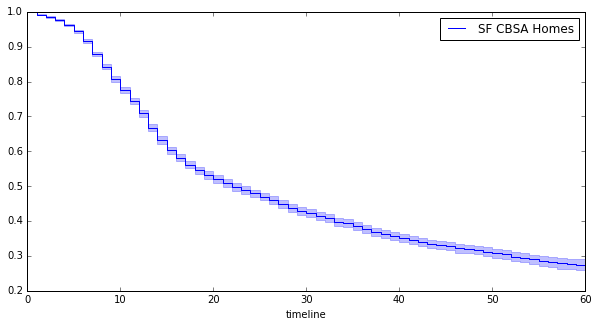

In [160]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
kmf.fit(T, event_observed=E, label = "SF CBSA Homes"); # more succiently, kmf.fit(T,E)

kmf.survival_function_
kmf.median_
kmf.plot(xlim = 0);

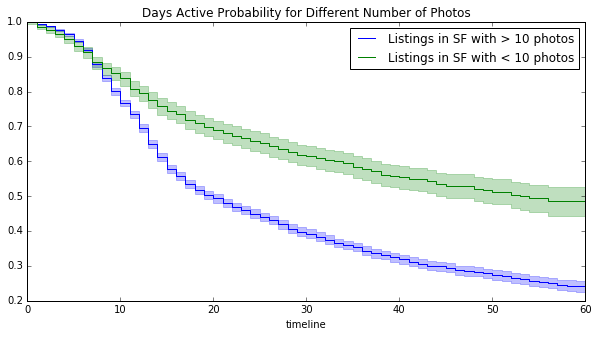

In [161]:
#Photo Counts
groups = listings_df['photo_count']
ten_photos_or_less = (groups <= 10)

kmf.fit(T[~ten_photos_or_less], E[~ten_photos_or_less], label='Listings in SF with > 10 photos')
ax = kmf.plot()

kmf.fit(T[ten_photos_or_less], E[ten_photos_or_less], label='Listings in SF with < 10 photos')
kmf.plot(xlim=0,ax=ax,title="Days Active Probability for Different Number of Photos");

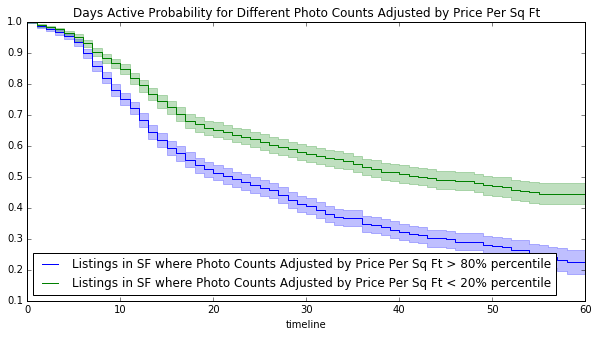

In [162]:
#Photo Counts Adjusted by Price Per Sq Ft
groups = listings_df['photos_per_psf']
more_photos_psf = (groups >= listings_df.photos_per_psf.quantile(.8))
fewer_photos_psf = (groups <= listings_df.photos_per_psf.quantile(.2))

kmf.fit(T[more_photos_psf], E[more_photos_psf], label='Listings in SF where Photo Counts Adjusted by Price Per Sq Ft > 80% percentile')
ax = kmf.plot()

kmf.fit(T[fewer_photos_psf], E[fewer_photos_psf], label='Listings in SF where Photo Counts Adjusted by Price Per Sq Ft < 20% percentile')
kmf.plot(xlim=0,ax=ax,title="Days Active Probability for Different Photo Counts Adjusted by Price Per Sq Ft");

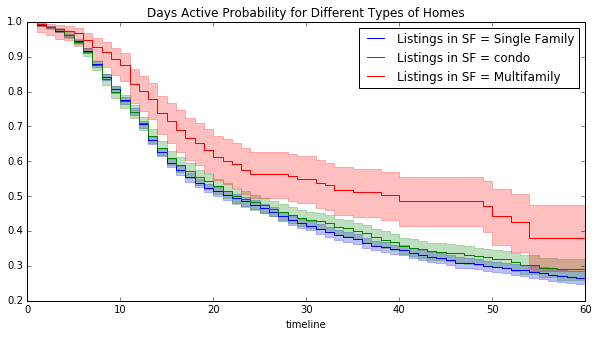

In [163]:
#Types of Home
groups = listings_df['type']
single = (groups == 'single_family')
multi = (groups == 'multi_family')
condo = (groups == 'condo')
ax = plt.subplot(111)

kmf.fit(T[single], E[single], label='Listings in SF = Single Family')
ax = kmf.plot(ax=ax)

kmf.fit(T[condo], E[condo], label='Listings in SF = condo')
ax = kmf.plot(ax=ax)

kmf.fit(T[multi], E[multi], label='Listings in SF = Multifamily')
kmf.plot(xlim=0,ax=ax,title="Days Active Probability for Different Types of Homes");

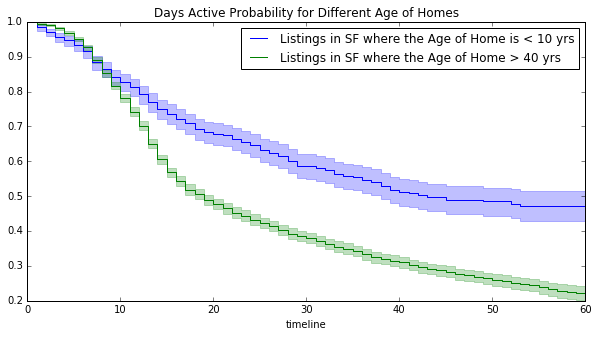

In [164]:
#Age of Homes
groups = listings_df['home_age']
new = (groups <= 10)
old = (groups >= 40)

kmf.fit(T[new], E[new], label='Listings in SF where the Age of Home is < 10 yrs')
ax = kmf.plot()

kmf.fit(T[old], E[old], label='Listings in SF where the Age of Home > 40 yrs')
kmf.plot(xlim=0,ax=ax,title="Days Active Probability for Different Age of Homes");

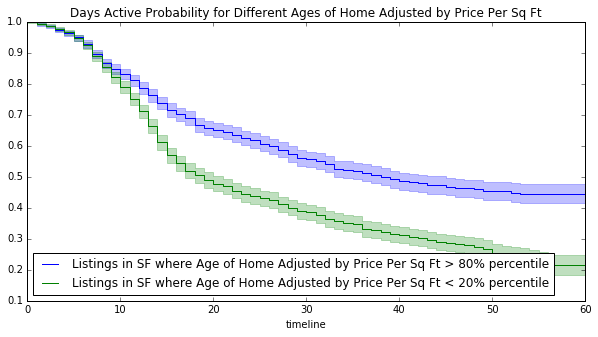

In [166]:
#Age of Home Adjusted by Price Per Sq Ft
groups = listings_df['home_age_psf']
more_photos_psf = (groups >= listings_df.home_age_psf.quantile(.8))
fewer_photos_psf = (groups <= listings_df.home_age_psf.quantile(.2))

kmf.fit(T[more_photos_psf], E[more_photos_psf], label='Listings in SF where Age of Home Adjusted by Price Per Sq Ft > 80% percentile')
ax = kmf.plot()

kmf.fit(T[fewer_photos_psf], E[fewer_photos_psf], label='Listings in SF where Age of Home Adjusted by Price Per Sq Ft < 20% percentile')
kmf.plot(xlim=0,ax=ax,title="Days Active Probability for Different Ages of Home Adjusted by Price Per Sq Ft");

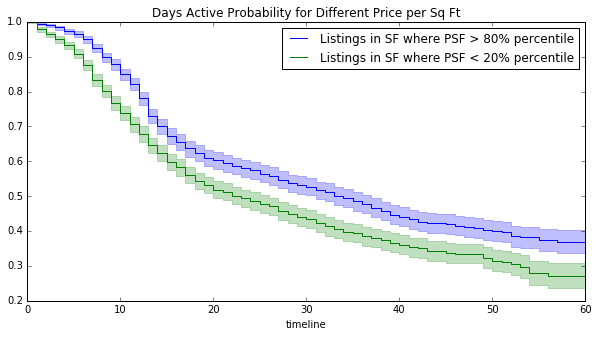

In [44]:
#Price Per SF
groups = listings_df['price_psf']
expensive = (groups >= listings_df.price_psf.quantile(.8))
cheap = (groups <= listings_df.price_psf.quantile(.2))

kmf.fit(T[expensive], E[expensive], label='Listings in SF where PSF > 80% percentile')
ax = kmf.plot()

kmf.fit(T[cheap], E[cheap], label='Listings in SF where PSF < 20% percentile')
kmf.plot(xlim=0,ax=ax,title="Days Active Probability for Different Price per Sq Ft");

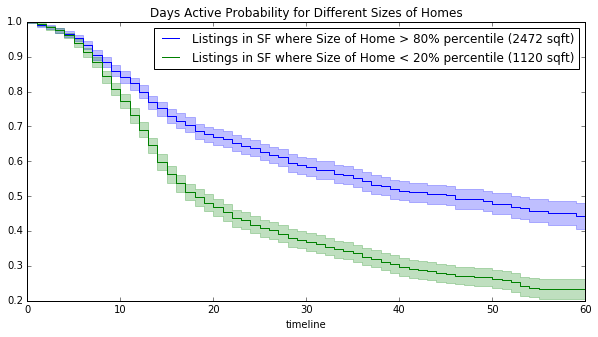

In [45]:
#Size of Home
groups = listings_df['sqft']
large = (groups >= listings_df.sqft.quantile(.8))
small = (groups <= listings_df.sqft.quantile(.2))

kmf.fit(T[large], E[large], label='Listings in SF where Size of Home > 80% percentile (2472 sqft)')
ax = kmf.plot()

kmf.fit(T[small], E[small], label='Listings in SF where Size of Home < 20% percentile (1120 sqft)')
kmf.plot(xlim=0,ax=ax,title="Days Active Probability for Different Sizes of Homes");

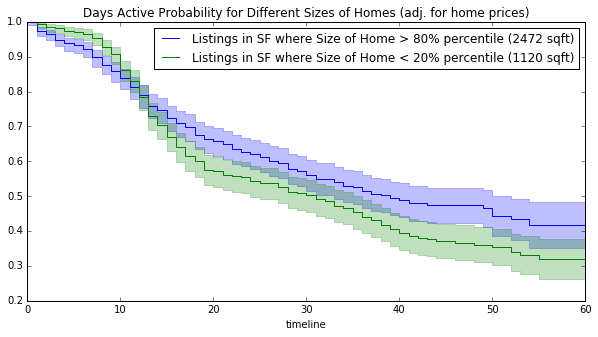

In [46]:
#Size of Home (Adjusted for Home Prices by looking at Large and Cheap Homes v Small and Expensive Homes)
groups = listings_df['sqft']
large = (groups >= listings_df.sqft.quantile(.8))
small = (groups <= listings_df.sqft.quantile(.2))

kmf.fit(T[large & cheap], E[large & cheap], label='Listings in SF where Size of Home > 80% percentile (2472 sqft)')
ax = kmf.plot()

kmf.fit(T[small & expensive], E[small & expensive], label='Listings in SF where Size of Home < 20% percentile (1120 sqft)')
kmf.plot(xlim=0,ax=ax,title="Days Active Probability for Different Sizes of Homes (adj. for home prices)");

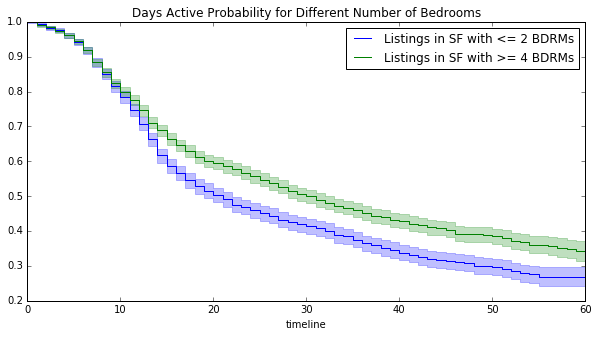

In [47]:
#Bedroom Counts
groups = listings_df['bedrooms']
two = (groups <= 2)
four = (groups >= 4)


kmf.fit(T[two], E[two], label='Listings in SF with <= 2 BDRMs')
ax = kmf.plot()

kmf.fit(T[four], E[four], label='Listings in SF with >= 4 BDRMs')
kmf.plot(xlim=0,ax=ax,title="Days Active Probability for Different Number of Bedrooms");

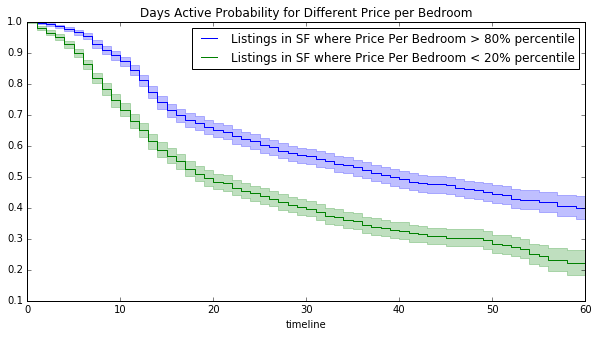

In [116]:
#Price Per Bedroom
groups = listings_df['price_per_bedroom']
expensive_per_bedroom = (groups >= listings_df.price_per_bedroom.quantile(.8))
cheap_per_bedroom = (groups <= listings_df.price_per_bedroom.quantile(.2))

kmf.fit(T[expensive_per_bedroom], E[expensive_per_bedroom], label='Listings in SF where Price Per Bedroom > 80% percentile')
ax = kmf.plot()

kmf.fit(T[cheap_per_bedroom], E[cheap_per_bedroom], label='Listings in SF where Price Per Bedroom < 20% percentile')
kmf.plot(xlim=0,ax=ax,title="Days Active Probability for Different Price per Bedroom");

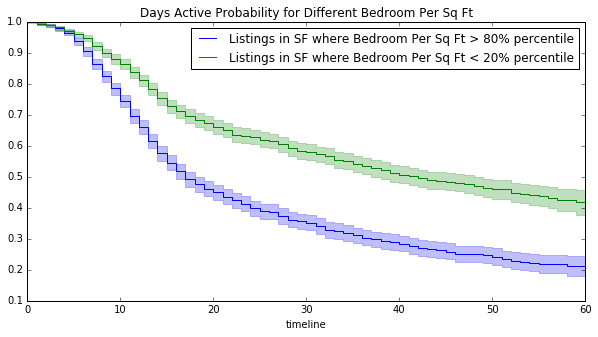

In [79]:
#Bedroom Per Sq Ft
groups = listings_df['bedrooms_per_sf']
more_bedrooms = (groups >= listings_df.bedrooms_per_sf.quantile(.8))
fewer_bedrooms = (groups <= listings_df.bedrooms_per_sf.quantile(.2))

kmf.fit(T[more_bedrooms], E[more_bedrooms], label='Listings in SF where Bedroom Per Sq Ft > 80% percentile')
ax = kmf.plot()

kmf.fit(T[fewer_bedrooms], E[fewer_bedrooms], label='Listings in SF where Bedroom Per Sq Ft < 20% percentile')
kmf.plot(xlim=0,ax=ax,title="Days Active Probability for Different Bedroom Per Sq Ft");

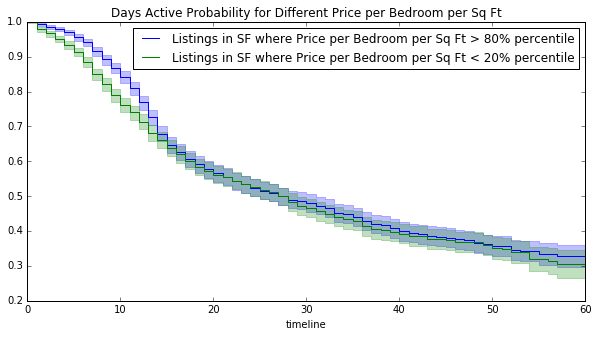

In [117]:
#Price per Bedroom per Sq Ft
groups = listings_df['price_per_bedroom_per_sf']
adjusted_expensive = (groups >= listings_df.price_per_bedroom_per_sf.quantile(.8))
adjusted_cheap = (groups <= listings_df.price_per_bedroom_per_sf.quantile(.2))

kmf.fit(T[adjusted_expensive], E[adjusted_expensive], label='Listings in SF where Price per Bedroom per Sq Ft > 80% percentile')
ax = kmf.plot()

kmf.fit(T[adjusted_cheap], E[adjusted_cheap], label='Listings in SF where Price per Bedroom per Sq Ft < 20% percentile')
kmf.plot(xlim=0,ax=ax,title="Days Active Probability for Different Price per Bedroom per Sq Ft");

### Cox Regression to Predict Days Active on RDC

In [333]:
cox_df = listings_df[['price','bedrooms','sqft','home_age','photo_count','T','E']]

In [334]:
#ADD INTERACTION TERMS
import warnings
warnings.filterwarnings('ignore')

cox_df['bedrooms*price'] = cox_df.bedrooms * cox_df.price
cox_df['sqft*price'] = cox_df.sqft * cox_df.price
cox_df['bedrooms*sqft'] = cox_df.bedrooms * cox_df.sqft
# cox_df['bedrooms*sqft*price'] = cox_df.bedrooms * cox_df.sqft * cox_df.price
# cox_df['photo_count*price'] = cox_df.photo_count * cox_df.price #NOT SIGNIFICANT
# cox_df['home_age*price'] = cox_df.home_age * cox_df.price #NOT SIGNIFICANT

T = cox_df['T']
E = cox_df['E']

In [335]:
cox_df.head()

,price,bedrooms,sqft,home_age,photo_count,T,E,bedrooms*price,sqft*price,bedrooms*sqft
1,840000,3.0,1560.0,45.0,24,21,1,2520000.0,1.310400e+09,4680.0
2,1395000,3.0,3365.0,29.0,30,23,0,4185000.0,4.694175e+09,10095.0
5,1695000,4.0,3523.0,78.0,30,33,0,6780000.0,5.971485e+09,14092.0
6,799000,4.0,1536.0,44.0,30,13,1,3196000.0,1.227264e+09,6144.0
8,825000,3.0,1310.0,66.0,22,11,1,2475000.0,1.080750e+09,3930.0


In [336]:
train_df = cox_df.ix[1000:,]
test_df = cox_df.ix[:999,]

In [337]:
from lifelines import CoxPHFitter

cf = CoxPHFitter()
cf.fit(cox_df, 'T', 'E', include_likelihood=True)
cf.print_summary()

n=10131, number of events=5107

                     coef  exp(coef)  se(coef)          z         p  lower 0.95  upper 0.95     
price          -5.679e+00  3.418e-03 6.158e-01 -9.222e+00 2.924e-20  -6.886e+00  -4.471e+00  ***
bedrooms        2.018e-01  1.224e+00 3.440e-02  5.867e+00 4.447e-09   1.344e-01   2.693e-01  ***
sqft           -6.307e-02  9.389e-01 7.155e-02 -8.814e-01 3.781e-01  -2.033e-01   7.720e-02     
home_age        4.413e-02  1.045e+00 1.459e-02  3.025e+00 2.484e-03   1.553e-02   7.272e-02   **
photo_count     2.287e-01  1.257e+00 1.546e-02  1.479e+01 1.663e-49   1.983e-01   2.590e-01  ***
bedrooms*price  1.654e+00  5.228e+00 5.389e-01  3.069e+00 2.147e-03   5.975e-01   2.710e+00   **
sqft*price      5.111e-01  1.667e+00 1.031e-01  4.956e+00 7.195e-07   3.089e-01   7.132e-01  ***
bedrooms*sqft  -4.839e-01  6.164e-01 1.019e-01 -4.749e+00 2.044e-06  -6.836e-01  -2.841e-01  ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Concordance = 0.597


In [271]:
# fig, axes = plt.subplots(nrows=1, ncols=2, squeeze=False, sharex=True)
# cf.baseline_cumulative_hazard_.plot(ax=axes[0,0], legend=False
#                 ,title='Baseline cumulative hazard rate')
# cf.baseline_survival_.plot(ax=axes[0,1], legend=False
#                 ,title='Baseline survival rate');

In [338]:
test_df = test_df[test_df['E']==0] #Test only those that have become pending

In [341]:
result = pd.DataFrame()
result['median'] = cf.predict_median(test_df)[0.5].values
result['75th_perc'] = cf.predict_percentile(test_df,.75)[0.75].values
result['25th_perc'] = cf.predict_percentile(test_df,.25)[0.25].values
result['actual'] = test_df['T'].values

#Replace High End estimate with Max days
result['25th_perc'] = result['25th_perc'].replace([np.inf, -np.inf], (final_date - start_date).days)

#Replace Low End estimate with Min days
result['75th_perc'] = result['75th_perc'].replace([np.inf, -np.inf], 0)

#Check how many are within range
result['within_range'] = (result['75th_perc'] <= result['actual']) & (result['25th_perc'] >= result['actual'])

In [347]:
print "Percentage of predicted data points that fell within range", result['within_range'].sum() * 1.0 / result.shape[0]

Percentage of predicted data points that fell within range 0.651376146789


In [348]:
# cf.predict_survival_function(test_df).plot(xlim=0);

In [309]:
from lifelines.utils import k_fold_cross_validation
cf = CoxPHFitter()
scores = k_fold_cross_validation(cf, cox_df, 'T', event_col='E', k=3) 
print scores
print np.mean(scores)
print np.std(scores)

[0.5809705795635639, 0.59555601371173139, 0.61067924093425896]
0.59573527807
0.0121291725987
